# Robust Inverse State Feedback Control Design

In this notebook we consider nonlinear systems with time-varying uncertain variable and present robust controller design that enforce an arbitary degree of attentuation of the effect of uncertainty on output of closed loop system.

In particular, we examine the descriptive example given in *Control of nonlinear and hybrid process systems: Designs for uncertainty, constraints and time-delays (Christofides & El-Farra, 2005).*

This notebook is a reference source for the final project for the course of ECH-267: Advanced Process Control. 

### Directions to reproduce the results for a different system:

- Define Process Parameters
- Define the model in the function CSTR/dUdt
- Calculate the Lie-Derivatives for your system (An easy way to do so will be changing the variables to dimensionless form)
- Change the Lie-Derivatives in the controller functions defined 


## Illustrative example

Consider an isothermal chemical reactor with irreversible first order exothermic reaction.
$$
    \begin{aligned}
        A & \to B \\
    \end{aligned}
$$
Under the standard modelling assumptions, the mathematical model for the process takes form:

\begin{aligned}
\frac{{dC}_{\text{A}}}{dt} &= \frac{F}{V} \cdot (C_{\text{A},0} - C_{\text{A}}) - k_0 \cdot exp(\frac{E}{RT}) \cdot C_{\text{A}} \\
\frac{dT}{dt} &= \frac{F}{V} \cdot (T_{\text{A},0} - T_{\text{A}}) - \frac{∆H_{nom}}{\rho c_p}k_0 \cdot exp(\frac{E}{RT}) \cdot C_{\text{A}} + \frac{Q}{\rho c_p V} \\
\end{aligned}


In [2]:
# Import necessary libraries 

import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.integrate import odeint
from sympy import *
from scipy.optimize import fsolve

In [5]:
# Defining the process parameters:

V = 100          #L
A = 6.0          #m^2
R = 8.314
Ca0 = 1          #mol/L
Ta0 = 300        #K
Tcs = 320.0      #K
delH= 718e3      #718 J/mol
k = 7            #min-1
E = 27400        #J/mol
cp = 0.239       #0.239 J/g
rho = 1000       #g/L
F = 100          #L/min
Cas = 0.731      #mol/L
Ts = 1098.5      #K


## Stability Analysis

Here, we conduct the stabolity analysis of the equilibrium points (steady state points). In this process for an open-loop system with Q=0, we get an unstable equilibrium point at $C_{As} = 0.731 mol/L$ and $T_s = 1098.5 K.$

The control objective is regulation of reactant concentration at unstable equilibrium point, in presence of time-varying persistent disturbances in feed temperature and uncertainty in heat of reaction by manipulting the rate of heat input Q. We will design various controllers based on the methods decribed in the text.


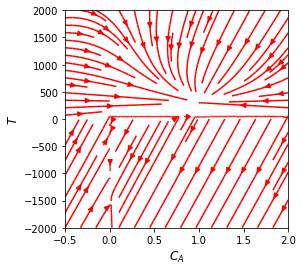

In [13]:
# Defining the model for phase potraits

def dUdt(U, t):
    Ca, T = U

    dCdt = (F/V)*(Ca0 - Ca) -k*np.exp(-E/(R*T))*Ca
    dTdt = (F/V)*(Ta0 - T) + (-delH/(rho*cp))*k*np.exp(-E/(R*T))*Ca

    return [dCdt, dTdt]

x1 = np.linspace(-0.5, 2.0, 50)
x2 = np.linspace(-2000.0, 2000.0, 50)
X1, X2 = np.meshgrid(x1, x2)

t = 0

u, v = np.zeros(X1.shape), np.zeros(X2.shape)

NI, NJ = X1.shape

for i in range(NI):
    for j in range(NJ):
        x = X1[i, j]
        y = X2[i, j]
        xprime = dUdt([x, y], t)
        u[i,j] = xprime[0]
        v[i,j] = xprime[1]
     

Q = plt.figure(figsize=(4,4))
Q = plt.streamplot(X1, X2, u, v, color='r')


plt.xlabel('$C_A$',fontsize=12)
plt.ylabel('$T$',fontsize=12)
plt.savefig('Final-Stability Analysis')
plt.show()

## System modelling

Defining the variables:

 $x_1$ = $\frac{(C_{\text{A}} − C_{\text{As}})}{C_{\text{As}}}$  
 
 $x_2$ = $\frac{(T − T_{\text{s}})}{T_{\text{s}}}$
 
 $u$ = $\frac{Q}{ρmc_pVT_s}$
 
 $θ_1(t)$ = ${(C_{\text{A}} − C_{\text{As}})}$
 
 $θ_2(t)$ = $∆H$ − $∆H_{nom}$
 
 $y$ = $x_1$ 


In [3]:
# Defining the model along with the uncertainties

def cstr(f, t, u):
    x1 = f[0]
    x2 = f[1]
    d = (1 + x1)*np.exp(2 - 3/(x2 +1))
    dx1dt = 0.368 - x1 - d 
    dx2dt = -0.736 - x2 +2*d + u + (1/Ts)*30*np.sin(t) + (Cas/(rho*cp*Ts))*d*28.7*np.sin(t)
    dfdt = [dx1dt, dx2dt]
    return dfdt


## Open-Loop Simulations at the unstable steady-state point

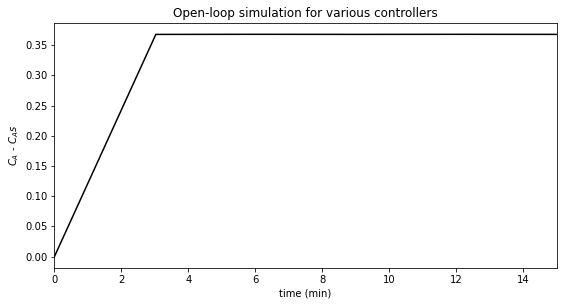

In [14]:
t =np.linspace(0,300,100)
u= np.zeros(100)
x1 = np.empty_like(t)
x2 = np.empty_like(t)
f0 = [(Ca0-Cas)/Cas,(Ta0-Ts)/Ts]


for i in range (1,100):
    tspan = [t[i-1],t[i]]
        
    # solve for next step
    f = odeint(cstr,f0,tspan,args=(u[i],))
    x1[i] = f[1][0]
    x2[i] = f[1][1]
    # next initial condition
    f0 = f[1]

fig1 = plt.figure(figsize=(9, 5))
plt.plot(t,x1, 'k', label='$x_1$(t)')
plt.xlim(0,15)
plt.xlabel('time (min)')
plt.ylabel('$C_A$ - $C_As$')
plt.title('Open-loop simulation for various controllers')
plt.savefig('Final Project-Open Loop')
plt.show()

## Closed-loop Simulations for Various Controllers described in the book

- Function defined as sontag is a sontag-like controller with various Chi values (Eqn 3.18-3.21 in the book)
- Function defined as feedback is a feedback-linearization like controller (Eqn 3.31 in the book)
- Function defined as highgain is the high-gain controller

In [35]:

# Designing a Controller of form of equation 3.18-3.21 

def sontag(c0,Rho,chi,phi):
    # Initial Conditions
    
    f0 = [(Ca0-Cas)/Cas,(Ta0-Ts)/Ts]
    
    # Controller parameters
    
    u= np.zeros(100)
    x1 = np.empty_like(t)
    x2 = np.empty_like(t)
    dx1dt = np.empty_like(t)
    dx2dt = np.empty_like(t)
    x1[0] = f0[0]
    x2[0] = f0[1]
    d = np.empty_like(t)
    LfV = np.empty_like(t)
    LgV = np.empty_like(t)
    LgLfh = np.empty_like(t)
    rs = np.empty_like(t)
    rc = np.empty_like(t)
    rd = np.empty_like(t)
    k = np.empty_like(t)
    
    # Defining a iterating loop for simulation
    
    for i in range(1,100):
        # span for next time step
        
        tspan = [t[i-1],t[i]]
        
        # solve for next step
        f = odeint(cstr,f0,tspan,args=(u[i],))
        
        # store solution for plotting
        dx1dt[i] = 0.368 - x1[i] - d[i] 
        dx2dt[i] = -0.736 - x2[i] +2*d[i]
        d[i] = (1 + x1[i])*np.exp(2 - 3/(x2[i] +1))
        
        # Defining solved Lie-Derivatives
        LfV[i] = dx1dt[i]*(1+0.9*dx1dt[i])+ (1 + 0.9*x1[i])*(-dx1dt[i]-dx1dt[i]*np.exp(2 - 3/(x2[i] +1))) - (1 + 0.9*x1[i])*d[i]*(-3*np.log(x2[i] + 1))*dx2dt[i]
        LgV[i] = d[i]*(-3*np.log(x2[i] + 1))*(1 + 0.9*x1[i])
        LgLfh[i] = d[i]*(3*np.log(x2[i] + 1))
        rs[i] = (LfV[i] + np.sqrt(LfV[i]**2 + LgV[i]**4))/(LgV[i]**2)
        rd[i] = (Rho + chi*30/Ts + chi*28.7*Cas/(rho*cp*Ts))/(LgLfh[i]**2*(abs(LgV[i]/LgLfh[i])+phi))
        rc[i] = (Rho + chi*30/Ts + chi*28.7*Cas/(rho*cp*Ts))/(LgLfh[i]**2*phi)
        k[i] = c0 + rs[i] + rd[i]
        if LgV[i] != 0:
            u[i] = -k[i]*LgV[i] 
        else:
            u[i] = -(c0 + rc[i])*LgV[i]
        x1[i] = f[1][0]
        x2[i] = f[1][1]
        # next initial condition
        f0 = f[1]
    x1 -= 0.36790
    return [x1,x2]

# Defining the model for Next Controller

def cstr1(f, t, u):
    x1 = f[0]
    x2 = f[1]
    d = (1 + x1)*np.exp(2 - 3/(x2 +1))
    dx1dt = 0.368 - x1 - d 
    dx2dt = -0.736 - x2 +2*d + u
    LfV = f[0]*(1+0.9*f[0])+ (1 + 0.9*x1)*(-f[0]-f[0]*np.exp(2 - 3/(x2 +1))) - (1 + 0.9*x1)*d*(-3*np.log(x2 + 1))*f[1]
    LgV = d*(-3*np.log(x2 + 1))*(1 + 0.9*x1)
    dfdt = [dx1dt, dx2dt]
    return dfdt

# Designing a controller of form of equation 3.18-3.21 with X=0

def sontag1():
    f0 = [(Ca0-Cas)/Cas,(Ta0-Ts)/Ts]
    u= np.zeros(100)
    x1 = np.empty_like(t)
    x2 = np.empty_like(t)
    dx1dt = np.empty_like(t)
    dx2dt = np.empty_like(t)
    x1[0] = f0[0]
    x2[0] = f0[1]
    d = np.empty_like(t)
    LfV = np.empty_like(t)
    LgV = np.empty_like(t)
    d[0] = (1 + x1[0])*np.exp(2 - 3/(x2[0] +1))
    dx1dt[0] = 0.368 - x1[0] - d[0] 
    dx2dt[0] = -0.736 - x2[0] +2*d[0]
    
    LfV[0] = dx1dt[0]*(1+0.9*dx1dt[0])+ (1 + 0.9*x1[0])*(-dx1dt[0]-dx1dt[0]*np.exp(2 - 3/(x2[0] +1))) - (1 + 0.9*x1[0])*d[0]*(-3*np.log(x2[0] + 1))*dx2dt[0]
    LgV[0] = d[0]*(-3*np.log(x2[0] + 1))*(1 + 0.9*x1[0])
    if LgV[0] != 0:
        u[0] = -(LfV[0] + np.sqrt(LfV[0]**2 + LgV[0]**4))/LgV[0]
    else:
        u[0] = 0
    
    for i in range(1,100):
        # span for next time step
        tspan = [t[i-1],t[i]]
        # solve for next step
        
        f = odeint(cstr1,f0,tspan,args=(u[i],))
        # store solution for plotting
        
        dx1dt[i] = 0.368 - x1[i] - d[i] 
        dx2dt[i] = -0.736 - x2[i] +2*d[i]
        d[i] = (1 + x1[i])*np.exp(2 - 3/(x2[i] +1))
        LfV[i] = dx1dt[i]*(1+0.9*dx1dt[i])+ (1 + 0.9*x1[i])*(-dx1dt[i]-dx1dt[i]*np.exp(2 - 3/(x2[i] +1))) - (1 + 0.9*x1[i])*d[i]*(-3*np.log(x2[i] + 1))*dx2dt[i]
        LgV[i] = d[i]*(-3*np.log(x2[i] + 1))*(1 + 0.9*x1[i])
        if LgV[i] != 0:
            u[i] = -(LfV[i] + np.sqrt(LfV[i]**2 + LgV[i]**4))/LgV[i]
        else:
            u[i] = 0
        x1[i] = f[1][0]
        x2[i] = f[1][1]
        # next initial condition
        f0 = f[1]
    x1 -=0.36790
    return [x1, x2]

# Designing a controller of form of equation 3.31

def feedback():
    f0 = [(Ca0-Cas)/Cas,(Ta0-Ts)/Ts]
    t=np.linspace(0,15,100)
    u= np.zeros(100)
    x1 = np.empty_like(t)
    x2 = np.empty_like(t)
    dx1dt = np.empty_like(t)
    dx2dt = np.empty_like(t)
    x1[0] = f0[0]
    x2[0] = f0[1]
    d = np.empty_like(t)
    LgLfh = np.empty_like(t)
    Lf2h = np.empty_like(t)
    v = np.empty_like(t)
    
    for i in range(1,100):
        # span for next time step
        tspan = [t[i-1],t[i]]
        # solve for next step
        
        f = odeint(cstr1,f0,tspan,args=(u[i],))
        # store solution for plotting
        
        dx1dt[i] = 0.368 - x1[i] - d[i] 
        dx2dt[i] = -0.736 - x2[i] +2*d[i]
        d[i] = (1 + x1[i])*np.exp(2 - 3/(x2[i] +1))
        LgLfh[i] = d[i]*(3*np.log(x2[i] + 1))
        Lf2h[i] = -dx1dt[i] -dx1dt[i]*np.exp(2 - (3/(x2[i]+1))) - d[i]*(-3*np.log(x2[i] +1))*dx2dt[i]
        v[i] = -0.5*x1[i] - dx1dt[i]
        if LgLfh[i] != 0:
            u[i] = -(1/LgLfh[i])*(v[i]-Lf2h[i])
        else:
            u[i] = 0
        x1[i] = f[1][0]
        x2[i] = f[1][1]
        # next initial condition
        f0 = f[1]
    x1 -= 0.36790
    return [x1,x2]

# Defining high-gain controller

def highgain():
    f0 = [(Ca0-Cas)/Cas,(Ta0-Ts)/Ts]
   
    u= np.zeros(100)
    x1 = np.empty_like(t)
    x2 = np.empty_like(t)
    dx1dt = np.empty_like(t)
    dx2dt = np.empty_like(t)
    x1[0] = f0[0]
    x2[0] = f0[1]
    d = np.empty_like(t)
    LfV = np.empty_like(t)
    LgV = np.empty_like(t)
    rs = np.empty_like(t)
    k = np.empty_like(t)
    
    for i in range(1,100):
        # span for next time step
        tspan = [t[i-1],t[i]]
        # solve for next step
        
        f = odeint(cstr1,f0,tspan,args=(u[i],))
        # store solution for plotting
    
        dx1dt[i] = 0.368 - x1[i] - d[i] 
        dx2dt[i] = -0.736 - x2[i] +2*d[i]
        d[i] = (1 + x1[i])*np.exp(2 - 3/(x2[i] +1))
        LfV[i] = dx1dt[i]*(1+0.9*dx1dt[i])+ (1 + 0.9*x1[i])*(-dx1dt[i]-dx1dt[i]*np.exp(2 - 3/(x2[i] +1))) - (1 + 0.9*x1[i])*d[i]*(-3*np.log(x2[i] + 1))*dx2dt[i]
        LgV[i] = d[i]*(-3*np.log(x2[i] + 1))*(1 + 0.9*x1[i])
        rs[i] = (LfV[i] + np.sqrt(LfV[i]**2 + LgV[i]**4))/(LgV[i]**2)
        k[i] = 0.0001+ rs[i] 
        if LgV[i] != 0:
            u[i] = -20*k[i]*LgV[i] 
        else:
            u[i] = 0
        x1[i] = f[1][0]
        x2[i] = f[1][1]
        # next initial condition
        f0 = f[1]
    x1 -=0.367875
    return [x1,x2]


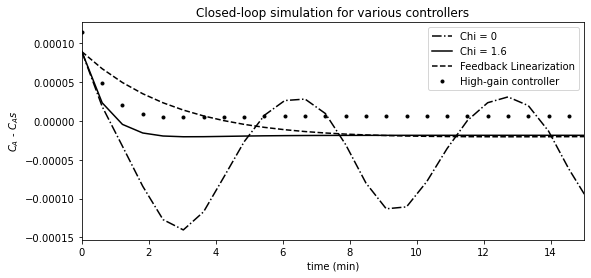

In [36]:
# Simulating and Generating plots

t = np.linspace(0,60,100)

fig = plt.figure(figsize=(9, 4))
plt.plot(t,sontag(0.0001,0,0,0.0001)[0],'k-.',label='Chi = 0')
plt.plot(t,sontag1()[0], 'k-',label='Chi = 1.6')
plt.plot(t, feedback()[0], 'k--', label='Feedback Linearization')
plt.plot(t,highgain()[0], 'k.', label='High-gain controller')
plt.legend(loc='best')
plt.xlim(0,15)
plt.xlabel('time (min)')
plt.ylabel('$C_A$ - $C_As$')
plt.title('Closed-loop simulation for various controllers')
plt.savefig('Final Project')
plt.show()